In [23]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import torch
from torch.utils.data import DataLoader
import pickle as pkl
from persite_painn.nn.builder import get_model_list
from persite_painn.data import collate_dicts
from persite_painn.utils.train_utils import test_model_list
# from persite_painn.train import Normalizer, load_model"
from persite_painn.utils import ensemble_inference, plot_violin
import numpy as np
from persite_painn.utils import plot_scatter
%config InlineBackend.figure_formats = ['svg']
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr

Download trained models (`m_painn` and `per_site_painn`) from our zenodo dataset [here](https://zenodo.org/records/10119944) to the `models` folder.

In [2]:
model_path = "models/m_painn/2_components/"
model_list = get_model_list(model_path=model_path, model_type="PainnMultifidelity")

baseline_model_path = "models/per_site_painn"
baseline_model_list = get_model_list(model_path=baseline_model_path, model_type="Painn")

In [4]:
test_dataset = torch.load("../data_cache/testset")
test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    num_workers=0,
    collate_fn=collate_dicts,
)

## m-PaiNN

In [5]:
test_preds,test_targets, test_ids,test_preds_fidelity, test_targets_fidelity = test_model_list(model_list,
    test_loader,
    "cuda",
    normalizer=None,
    multifidelity=True,
)

O adsorption: 28, OH adsorption: 27


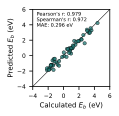

In [19]:
targs_O = []
targs_OH = []

preds_O = []
preds_OH = []

for batch in test_targets:
    for site in batch:
        targs_O.append(site[0])
        targs_OH.append(site[1])

for batch in test_preds:
    for site in batch:
        preds_O.append(site[0])
        preds_OH.append(site[1])

nan_filter_O = torch.bitwise_not(torch.isnan(torch.tensor(targs_O)))
# print(torch.tensor(targs_O).shape, torch.tensor(preds_O).shape)
filtered_targs_O = torch.tensor(targs_O)[nan_filter_O].tolist()
filtered_preds_O = torch.tensor(preds_O)[nan_filter_O].tolist()

nan_filter_OH = torch.bitwise_not(torch.isnan(torch.tensor(targs_OH)))
# print(torch.tensor(targs_OH).shape, torch.tensor(preds_OH).shape)
filtered_targs_OH = torch.tensor(targs_OH)[nan_filter_OH].tolist()
filtered_preds_OH = torch.tensor(preds_OH)[nan_filter_OH].tolist()
print(f"O adsorption: {len(filtered_targs_O)}, OH adsorption: {len(filtered_targs_OH)}")
combined_targs = []
combined_preds = []
for val in filtered_targs_O:
    combined_targs.append(val)
for val in filtered_targs_OH:
    combined_targs.append(val)
for val in filtered_preds_O:
    combined_preds.append(val)
for val in filtered_preds_OH:
    combined_preds.append(val)

fig_combined, _ ,_, mae = plot_scatter(combined_targs, combined_preds, num_col=4, target_index=0, prop_key="ads_e", facecolor="#1D7874", edgecolor='black', style='seaborn-bright')
fig_combined.tight_layout()
# fig_combined.savefig('m-painn.png', dpi=500, transparent=True)


# per-site PaiNN

In [7]:
test_preds_baseline,test_targets_baseline, test_ids_base_line,_, _ = test_model_list(baseline_model_list,
    test_loader,
    "cuda",
    normalizer=None,
    multifidelity=False,
)

O adsorption: 28, OH adsorption: 27


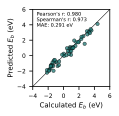

In [20]:
targs_O_baseline = []
targs_OH_baseline = []

preds_O_baseline = []
preds_OH_baseline = []

for batch in test_targets_baseline:
    for site in batch:
        targs_O_baseline.append(site[0])
        targs_OH_baseline.append(site[1])

for batch in test_preds_baseline:
    for site in batch:
        preds_O_baseline.append(site[0])
        preds_OH_baseline.append(site[1])

nan_filter_O_baseline = torch.bitwise_not(torch.isnan(torch.tensor(targs_O_baseline)))
# print(torch.tensor(targs_O).shape, torch.tensor(preds_O).shape)
filtered_targs_O_baseline = torch.tensor(targs_O_baseline)[nan_filter_O_baseline].tolist()
filtered_preds_O_baseline = torch.tensor(preds_O_baseline)[nan_filter_O_baseline].tolist()

nan_filter_OH_baseline = torch.bitwise_not(torch.isnan(torch.tensor(targs_OH_baseline)))
# print(torch.tensor(targs_OH).shape, torch.tensor(preds_OH).shape)
filtered_targs_OH_baseline = torch.tensor(targs_OH_baseline)[nan_filter_OH_baseline].tolist()
filtered_preds_OH_baseline = torch.tensor(preds_OH_baseline)[nan_filter_OH_baseline].tolist()
print(f"O adsorption: {len(filtered_targs_O_baseline)}, OH adsorption: {len(filtered_targs_OH_baseline)}")
combined_targs_baseline = []
combined_preds_baseline = []
for val in filtered_targs_O_baseline:
    combined_targs_baseline.append(val)
for val in filtered_targs_OH_baseline:
    combined_targs_baseline.append(val)
for val in filtered_preds_O_baseline:
    combined_preds_baseline.append(val)
for val in filtered_preds_OH_baseline:
    combined_preds_baseline.append(val)

fig_combined, _ ,_, mae = plot_scatter(combined_targs_baseline, combined_preds_baseline, num_col=4, target_index=0, prop_key="ads_e", facecolor="#1D7874", edgecolor='black', style='seaborn-bright')
fig_combined.tight_layout()
# fig_combined.savefig('persite-painn.png', dpi=500, transparent=True)


## Site Property Prediction

Download raw dataset `dataset_2_components.pkl` from our zenodo dataset [here](https://zenodo.org/records/10119944) to the `data_raw` folder.

In [9]:
original_dataset = pkl.load(open("../data_raw/dataset_2_components.pkl", "rb"))

In [10]:
def get_filtered_fidelity(targs, preds):
    targs_magmom = []
    targs_bandfilling = []
    targs_atomiccharges = []
    targs_bandcenter = []
    preds_magmom = []
    preds_bandfilling = []
    preds_atomiccharges = []
    preds_bandcenter = []
    for structure in targs:
        for site in structure:
            targs_bandcenter.append(site[0])
            targs_atomiccharges.append(site[1])
            targs_bandfilling.append(site[2])
            targs_magmom.append(site[3])
    for structure in preds:
        for site in structure:
            preds_bandcenter.append(site[0])
            preds_atomiccharges.append(site[1])
            preds_bandfilling.append(site[2])
            preds_magmom.append(site[3])

    nan_filter_bandfilling = torch.bitwise_not(torch.isnan(torch.tensor(targs_bandfilling)))
    filtered_targs_bandfilling = torch.tensor(targs_bandfilling)[nan_filter_bandfilling].tolist()
    filtered_preds_bandfilling = torch.tensor(preds_bandfilling)[nan_filter_bandfilling].tolist()

    nan_filter_bandcenter = torch.bitwise_not(torch.isnan(torch.tensor(targs_bandcenter)))
    filtered_targs_bandcenter = torch.tensor(targs_bandcenter)[nan_filter_bandcenter].tolist()
    filtered_preds_bandcenter = torch.tensor(preds_bandcenter)[nan_filter_bandcenter].tolist()

    nan_filter_atomiccharges = torch.bitwise_not(torch.isnan(torch.tensor(targs_atomiccharges)))
    filtered_targs_atomiccharges = torch.tensor(targs_atomiccharges)[nan_filter_atomiccharges].tolist()
    filtered_preds_atomiccharges = torch.tensor(preds_atomiccharges)[nan_filter_atomiccharges].tolist()

    nan_filter_magmom = torch.bitwise_not(torch.isnan(torch.tensor(targs_magmom)))
    filtered_targs_magmom = torch.tensor(targs_magmom)[nan_filter_magmom].tolist()
    filtered_preds_magmom = torch.tensor(preds_magmom)[nan_filter_magmom].tolist()
    removed_small_magmom_targs = []
    idx_bin = []
    for i, val in enumerate(filtered_targs_magmom):
        if val > 0.5:
            removed_small_magmom_targs.append(val)
            idx_bin.append(i)

    removed_small_magmom_preds = np.array(filtered_preds_magmom)[idx_bin]

    return (filtered_targs_bandcenter, filtered_preds_bandcenter), (filtered_targs_atomiccharges, filtered_preds_atomiccharges), (filtered_targs_bandfilling, filtered_preds_bandfilling), (removed_small_magmom_targs, removed_small_magmom_preds)

0.09687501318426103
0.10821743896851964
0.11169433888808411
0.17031889306135542


100%|██████████| 403/403 [00:00<00:00, 4833.76it/s]


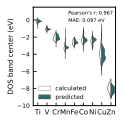

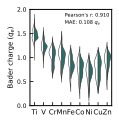

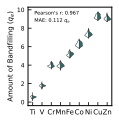

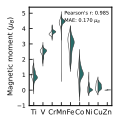

In [41]:
fidelity_mae_bin = []
bandcenters, atomiccharges, bandfillings, magmoms = get_filtered_fidelity(test_targets_fidelity, test_preds_fidelity)
mae_bandcenter  = mean_absolute_error(bandcenters[0], bandcenters[1])
r_bandcenter, _ = pearsonr(bandcenters[0], bandcenters[1])
print(mae_bandcenter)
mae_bader  = mean_absolute_error(atomiccharges[0], atomiccharges[1])
r_bader, _ = pearsonr(atomiccharges[0], atomiccharges[1])
print(mae_bader)

mae_bandfilling  = mean_absolute_error(bandfillings[0], bandfillings[1])
r_bandfilling, _ = pearsonr(bandfillings[0], bandfillings[1])
print(mae_bandfilling)

mae_magmom  = mean_absolute_error(magmoms[0], magmoms[1])
r_magmom, _ = pearsonr(magmoms[0], magmoms[1])
print(mae_magmom)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  0, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='bandcenter', color1="white",color2="#1D7874",Z_range=[22,23,24,25,26,27,28,29, 30], legend=True, style='seaborn-bright')
ax.figure.set_size_inches(1.80645161, 1.80645161)
ax.set_ylim(-10, 1.5)
ax.annotate(f"MAE: {mae_bandcenter:.3f} eV", (0.425,0.85), xycoords='axes fraction', fontsize=5)
ax.annotate(f"Pearson's r: {r_bandcenter:.3f}", (0.425,0.925), xycoords='axes fraction', fontsize=5)
fig.tight_layout()
# fig.savefig("bandcenter.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  1, num_col=4,test_ids=test_ids, structures=original_dataset,prop_key='bader', Z_range=[22,23,24,25,26,27,28,29, 30],color1="white",color2="#1D7874", legend=False, style='seaborn-bright')
ax.figure.set_size_inches(1.80645161, 1.80645161)
ax.annotate(f"MAE: {mae_bader:.3f} $q_e$", (0.425,0.85), xycoords='axes fraction', fontsize=5)
ax.annotate(f"Pearson's r: {r_bader:.3f}", (0.425,0.925), xycoords='axes fraction', fontsize=5)
ax.set_ylim(0.0, 2.0)
ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
yticks = ax.get_yticks()
fig.tight_layout()
# fig.savefig("atomiccharges.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  2, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='bandfilling', Z_range=[22,23,24,25,26,27,28,29, 30], color1="white",color2="#1D7874",legend=False, style='seaborn-bright')
ax.figure.set_size_inches(1.80645161, 1.80645161)
ax.annotate(f"MAE: {mae_bandfilling:.3f} $q_e$", (0.075,0.85), xycoords='axes fraction', fontsize=5)
ax.annotate(f"Pearson's r: {r_bandfilling:.3f}", (0.075,0.925), xycoords='axes fraction', fontsize=5)
fig.tight_layout()
# fig.savefig("bandfilling.png", dpi=500, transparent=True)

fig, ax = plot_violin(test_targets_fidelity, test_preds_fidelity,  3, num_col=4, test_ids=test_ids, structures=original_dataset,prop_key='magmom', Z_range=[22,23,24,25,26,27,28,29, 30], color1="white",color2="#1D7874",legend=False, style='seaborn-bright')
ax.figure.set_size_inches(1.80645161, 1.80645161)
ax.annotate(f"MAE: {mae_magmom:.3f} $\mu_B$", (0.425,0.85), xycoords='axes fraction', fontsize=5)
ax.annotate(f"Pearson's r: {r_magmom:.3f}", (0.425,0.925), xycoords='axes fraction', fontsize=5)
fig.tight_layout()
# fig.savefig("magmom.png", dpi=500, transparent=True)
